In [1]:
import sys
sys.path.append("../../")
import numpy as np
from tqdm import tqdm
import torch
from TorchInversion.TorchInversion import TorchInversion
from TorchInversion.propagators import Acoustic_Simulation
from TorchInversion.utils import dictToObj,numpy2tensor
from TorchInversion.plots import plot_model,plot_wavelet,plot_dampRegion,plot_observeSystem,wiggle
from TorchInversion.gradient_precond import grad_precond
from TorchInversion.demo import *

In [2]:
save_path = "./data/multiShotTop"

# initialize the Project
Project = TorchInversion(save_path=save_path)


2023-12-31 16:08:16,781:logs:INFO:Save To: ./data/multiShotTop
2023-12-31 16:08:16,782:logs:INFO:device: cuda:0
2023-12-31 16:08:16,784:logs:INFO:pid: 2263251


In [3]:
##################################
# load parameters
##################################
model_config,source,receiver,vel_model = Project.loadConfig()

##################################
# optimizer
##################################
lr = 10
iteration = 500
step_size = 100
gamma = 0.75
device = "cuda:0"
optim_setting = Project.optimConfig(lr=lr,iteration=iteration,step_size=step_size,gamma=gamma,device=device)

##################################
# set the initial model
##################################
dx,dy = model_config.dx,model_config.dy
nx,ny = model_config.nx,model_config.ny
x = np.arange(0,ny*dy/1000,dx/1000)
y = np.arange(0,nx*dx/1000,dy/1000)
step = 13 #km
layer_model = build_anomaly_backgroud_model(x, y, step)
anomaly_model = get_anomaly_model(layer_model, 15)      # true model
smooth_model = get_smooth_layer_model(layer_model)      # intial model

v = smooth_model['vp'].T*1000
rho = np.power(v, 0.25) * 310

v_true = anomaly_model['vp'].T*1000
rho_true = np.power(v_true, 0.25) * 310

vel_model = Project.vel_model(v=v,rho=rho,model_config=model_config)

##################################
# save the inversion param
##################################
param = Project.saveConfig(model_config,source,receiver,vel_model,optim_setting,inversion=True)

2023-12-31 16:08:16,986:logs:INFO:
 ================ Model settings ================
nx	:	 90
ny	:	 190
dx	:	 800
dy	:	 800
nt	:	 1001
dt	:	 0.038
pml	:	 20
fs	:	 1
nx_pml	:	 130
ny_pml	:	 230
vmax	:	 7844.943820224718
vmin	:	 5799.999999999999
2023-12-31 16:08:16,991:logs:INFO:
 ================ Source settings ================
f0	:	 1
src_x	:	 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
src_y	:	 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200
2023-12-31 16:08:16,992:logs:INFO:
 =============== Receiver settings ===============
rcv_x	:	 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
rcv_y	:	 1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81 

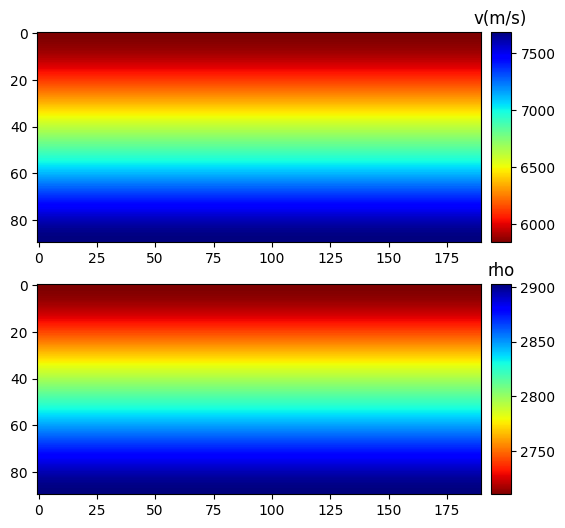

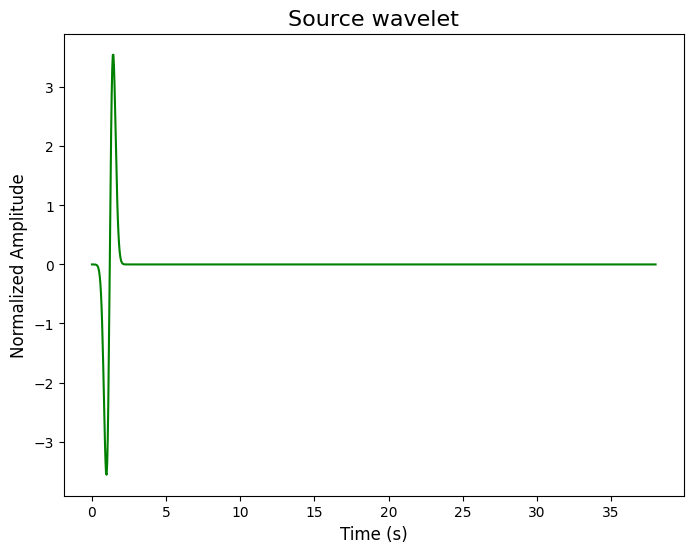

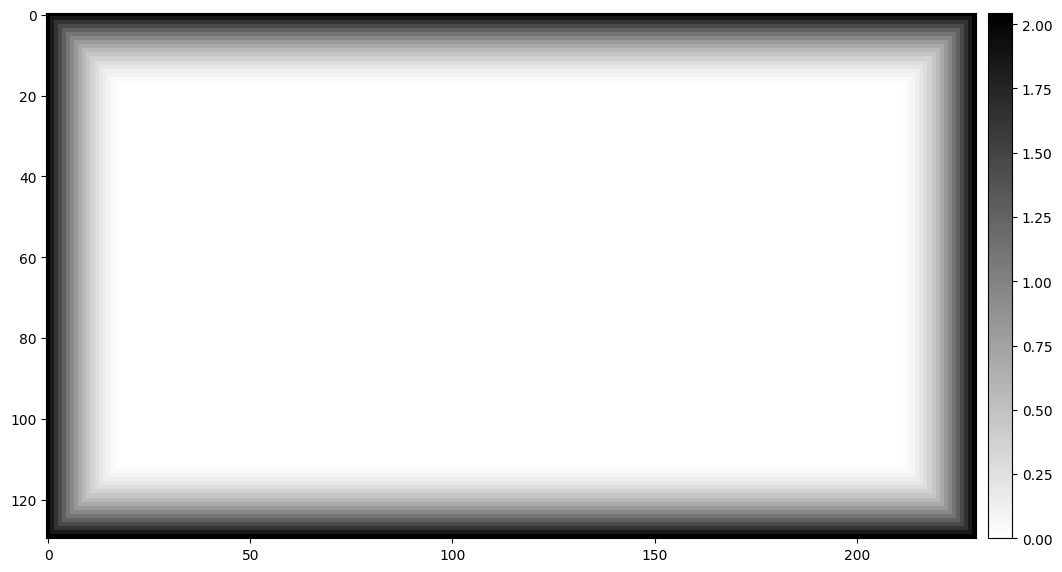

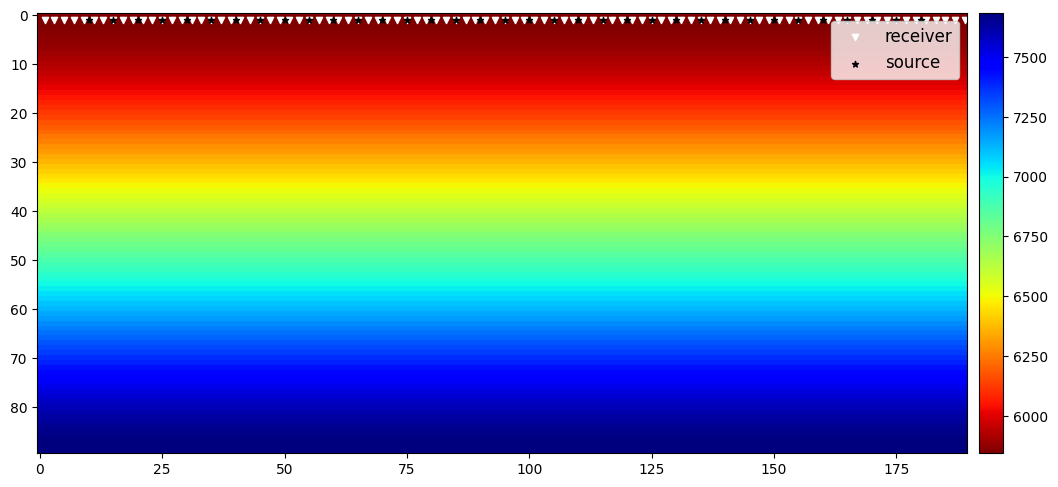

In [4]:
#Plot
plot_model(vel_model,save_path=os.path.join(save_path,"model/Initial/model_init.png"),show=True)
plot_wavelet(source,save_path=os.path.join(save_path,"model/Initial/ricker.png"),show=True)
plot_dampRegion(vel_model,save_path=os.path.join(save_path,"model/Initial/damp_global.png"),show=True)
plot_observeSystem(model_config,vel_model,source,receiver,save_path=os.path.join(save_path,"model/Initial/observed_system.png"),show=True)

In [5]:
#######################################
#         optimizer
#######################################
# observed data
csg_obs = np.load(os.path.join(save_path,"obs/obs.npz"))["obs_data"]

# grad precondition
grad_precondition = {
    "grad_mute":0,
    "grad_smooth":0,
    "marine_or_land":"land",
}

loss,inv_v = Project.inversion(csg_obs=csg_obs,normalize=True,grad_precondition=grad_precondition)


Using Adam to Iter the inversion


Iter:499,Loss:42.68: 100%|██████████| 500/500 [52:54<00:00,  6.35s/it]  
